# Evaluation of held out set

In [79]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.dummy import DummyRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from dataframe_builder import DbpediaTidyDataframeBuilder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score

from dbpedia_common import DataFrameRepository, FINAL_DBPEDIA_RAW_CSV, ALL_RELATIONS_CSV
from anomalies_analyser import compare_population_with_web
from models import get_svr_pipeline, get_linear_pipeline, get_lxgb_pipeline, ModelEvaluator


%matplotlib inline

### We create the held out set from scratch, using previously saved files. DbpediaTidyDataframeBuilder handles all the process for us

In [2]:
%%time
final_raw_df = pd.read_csv(FINAL_DBPEDIA_RAW_CSV)
relations_df = pd.read_csv(ALL_RELATIONS_CSV)
numeric_columns = [
    '<http://dbpedia.org/ontology/areaLand>',
    '<http://dbpedia.org/ontology/areaTotal>',
    '<http://dbpedia.org/ontology/areaWater>',
    '<http://dbpedia.org/ontology/elevation>',
    '<http://dbpedia.org/ontology/populationDensity>',
]

tidyDataframeBuilder = DbpediaTidyDataframeBuilder(final_raw_df, train_set=False)
(tidyDataframeBuilder
    .with_numeric_columns(numeric_columns) # Numeric columns like AreaTotal, Elevation, AreaWater and Flag columns
    .with_counter_columns()                # Counter columns like areaLand#count, birthPlace?inv#count, areaCode#count
    .with_rare_relations_count(relations_df) # One column rare relations (less than 5% of occurence)
    .with_total_relations_count()          # One column counting how many relations a subject has
    .with_unique_relations_count()         # One column counting how many relations a subject has, excluding duplicates.
    .with_place_types()  # adds place_types column, excluding duplicates or irrelevant.
    .with_offset_types() # adds offset_types column, after cleaning
    .with_countries()    # adds countries column, after cleaning
)
dbpedia_df = tidyDataframeBuilder.build()
dbpedia_df

CPU times: user 16.2 s, sys: 682 ms, total: 16.9 s
Wall time: 17 s


,subject,target,<http://dbpedia.org/ontology/areaLand>,<http://dbpedia.org/ontology/areaTotal>,<http://dbpedia.org/ontology/areaWater>,<http://dbpedia.org/ontology/elevation>,<http://dbpedia.org/ontology/populationDensity>,areaLand>NAN,areaTotal>NAN,areaWater>NAN,elevation>NAN,populationDensity>NAN,areaCode#count,areaLand#count,areaTotal#count,areaWater#count,birthPlace?inv#count,city?inv#count,country#count,countySeat?inv#count,deathPlace?inv#count,district#count,elevation#count,foundingDate#count,governmentType#count,gridReference#count,ground?inv#count,headquarter?inv#count,hometown?inv#count,largestCity?inv#count,licenceNumber#count,location?inv#count,motto#count,nearestCity?inv#count,originalName#count,politicalLeader#count,populationAsOf#count,populationDensity#count,postalCode#count,residence?inv#count,restingPlace?inv#count,routeEnd?inv#count,routeJunction?inv#count,routeStart?inv#count,subdivision#count,subdivision?inv#count,timeZone#count,type#count,utcOffset#count,22-rdf-syntax-ns#type#count,rdf-schema#seeAlso#count,homepage#count,name#count,nick#count,rare_rel#count,total_rel#count,unique_rel#count,place_type#cat,utc_offset#cat,country#cat
0,<http://dbpedia.org/resource/'Anata>,9600.000,0.000,30600000.000,0.000,0.000,0.000,1,0,1,1,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,1,24,14,NAN,NAN,State_of_Palestine
1,<http://dbpedia.org/resource/'Anin>,3719.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,6,0,0,1,0,1,20,10,NAN,NAN,State_of_Palestine
2,<http://dbpedia.org/resource/A_Coruña>,244850.000,0.000,37830000.000,0.000,0.000,6613.000,1,0,1,1,0,1,0,1,0,91,5,1,0,15,0,0,0,1,0,4,2,5,0,0,8,2,0,0,1,0,1,1,0,1,1,0,1,3,2,0,1,0,9,3,1,1,1,10,326,52,City,NAN,Spain
3,<http://dbpedia.org/resource/Aalborg>,140897.000,0.000,0.000,0.000,5.000,954.000,1,1,1,0,0,1,0,0,0,108,7,1,0,6,0,1,1,0,0,3,4,8,0,0,13,0,1,0,1,1,1,1,0,0,1,0,0,2,0,1,1,2,9,3,0,1,0,14,356,48,City,"1,2",Denmark
4,"<http://dbpedia.org/resource/Aalst,_Zaltbommel>",1986.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,2,0,2,1,2,8,0,0,1,0,1,38,18,Village,"1,2",Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9903,<http://dbpedia.org/resource/Želiezovce>,6772.000,0.000,56523000.000,0.000,137.000,0.000,1,0,1,0,1,1,0,1,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,2,0,2,1,2,8,3,1,1,0,2,60,32,Town,"1,2",Slovakia
9904,<http://dbpedia.org/resource/Želino>,4110.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,2,0,2,1,2,8,0,0,1,0,1,38,16,Village,"1,2",North_Macedonia
9905,<http://dbpedia.org/resource/Žemaičių_Naumiestis>,1373.000,0.000,0.000,0.000,0.000,0.000,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,2,8,0,0,1,0,1,30,12,Town,"2,3",Lithuania
9906,<http://dbpedia.org/resource/Živinice>,57765.000,0.000,291000000.000,0.000,0.000,198.000,1,0,1,1,0,1,0,1,0,8,0,1,0,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2,1,2,9,0,1,3,0,2,70,30,City,"1,2",Bosnia_and_Herzegovina


### Base Regressor, using the mean as estimator

DummyRegressor RMSLE: 0.7000827750326387
DummyRegressor MSLE: 489675.49886912404
DummyRegressor R2: 0.0


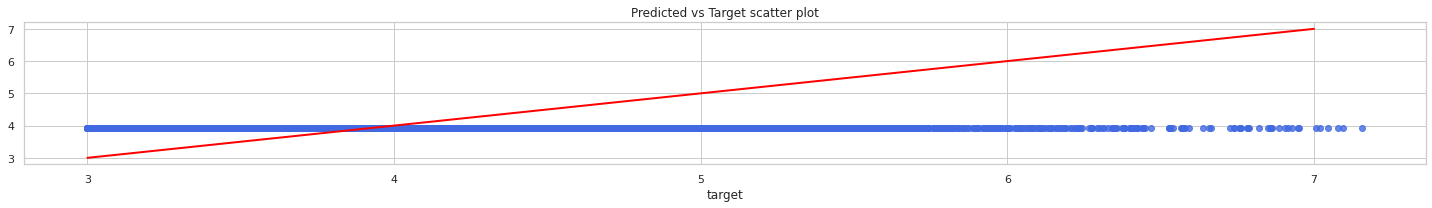

In [3]:
dummy_regr = DummyRegressor(strategy='mean')
X_test = dbpedia_df.drop(columns=['subject', 'target'])
y_test = np.log10(dbpedia_df.target)
y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

dummy_regr.fit(X_test, y_test)
pred = dummy_regr.predict(X_test)

print(f'DummyRegressor RMSLE: {mean_squared_error(y_test, pred) ** 0.5}')
print(f'DummyRegressor MSLE: {mean_squared_error(10**y_test, 10**pred) ** 0.5}')
print(f'DummyRegressor R2: {r2_score(y_test, pred)}')

fig, ax = plt.subplots(1, 1, figsize=(20,3))

sns.regplot(x=y_test, y=pred, ax=ax, color='royalblue', fit_reg=False)
ax.plot([3, 7], [3, 7], 'red', linewidth=2)
ax.set_title('Predicted vs Target scatter plot')
plt.tight_layout()

## Linear regression to find anomalies
 #### Pay atention to the red dots. Those are predictions with an error of more than 1.4 (log10 scale)

********************
Test RMSLE: 0.30687714676428285
Test RMSE: 875161.3065937638
Test R2 score: 0.8078544589900764
********************
Train RMSLE: 0.29282737585325763
Train RMSE: 313528.6185156103
Test R2 score: 0.8252054266513407


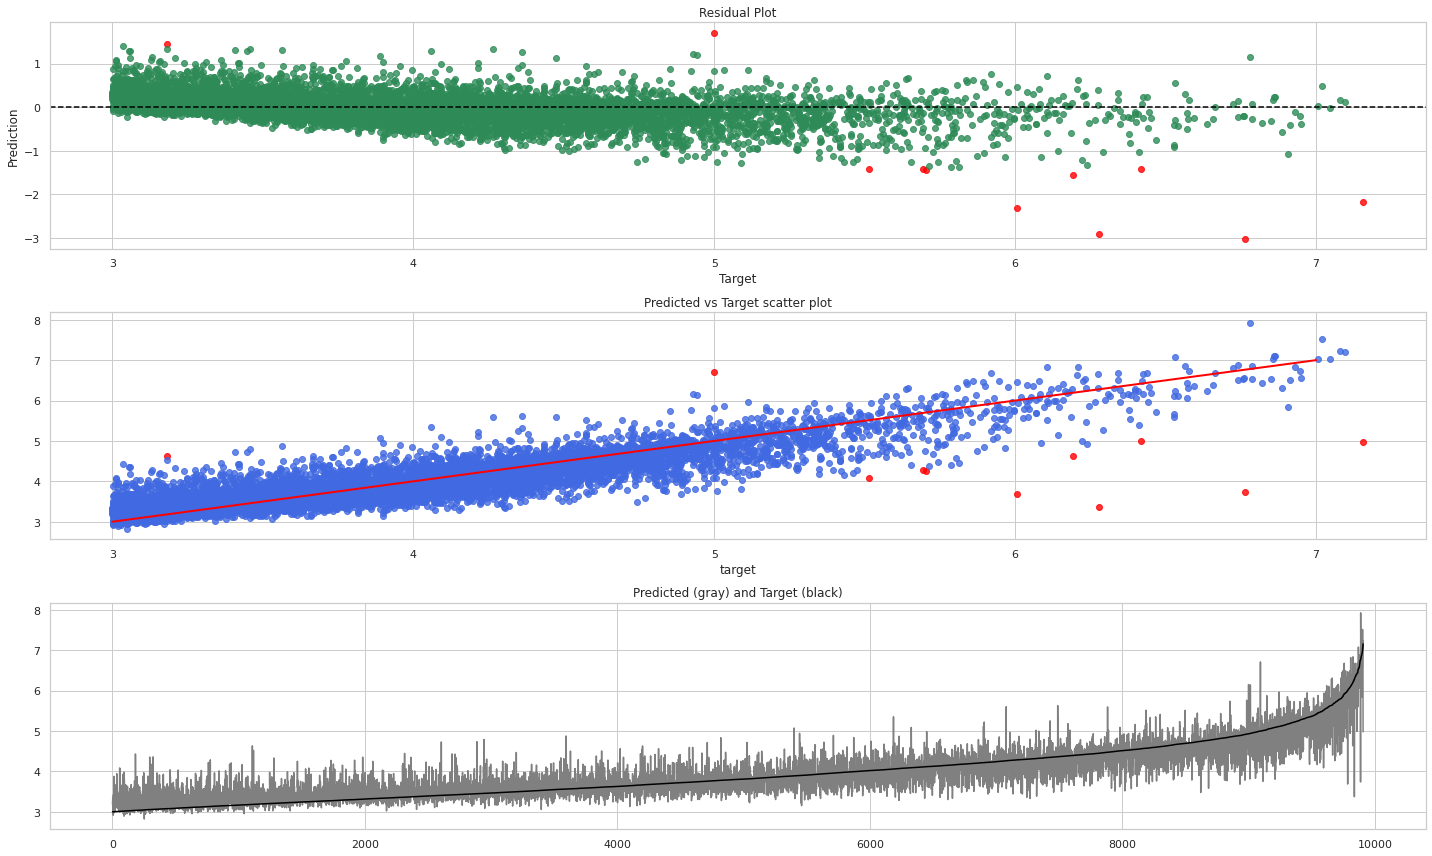

In [4]:
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)
y = train_df.target

X_test = dbpedia_df.drop(columns=['subject', 'target'])
y_test = np.log10(dbpedia_df.target)
y_test = y_test.sort_values() # These two lines are to have a nice plot below
X_test = X_test.reindex(y_test.index)

model = TransformedTargetRegressor(regressor=get_linear_pipeline(alpha=2, countries_threshold=0.97, utc_threshold=0.95),
                                   transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=True)
error_analysis_df = evaluator.get_error_analysis(dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)


### The subjects with bigger differences are: 
  * Adel Georgia
  * Sükösd
  * Tuba_City Arizona
  * Jaú

In [5]:
error_analysis_df.head(10)

,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
45,"Adel,_Georgia>",-3.030,6.762,3.733,5784936.000,5403.392,-5779532.608,"<http://dbpedia.org/resource/Adel,_Georgia>"
8486,Sükösd>,-2.910,6.277,3.367,1892512.000,2328.036,-1890183.964,<http://dbpedia.org/resource/Sükösd>
8859,"Tuba_City,_Arizona>",-2.309,6.006,3.697,1013162.000,4977.088,-1008184.912,"<http://dbpedia.org/resource/Tuba_City,_Arizona>"
4015,Jaú>,-2.198,7.156,4.958,14328300.000,90785.650,-14237514.350,<http://dbpedia.org/resource/Jaú>
4208,Karol_Bagh>,-1.467,5.703,4.237,505242.000,17257.129,-487984.871,<http://dbpedia.org/resource/Karol_Bagh>
5838,Munich>,1.464,5.000,6.464,100001.000,2911878.740,2811877.740,<http://dbpedia.org/resource/Munich>
8514,Taiz>,-1.462,6.417,4.955,2612222.000,90216.739,-2522005.261,<http://dbpedia.org/resource/Taiz>
3942,Ixtapaluca>,-1.454,5.695,4.241,495563.000,17426.961,-478136.039,<http://dbpedia.org/resource/Ixtapaluca>
6036,New_Athos>,1.430,3.181,4.611,1518.000,40827.333,39309.333,<http://dbpedia.org/resource/New_Athos>
6524,Pago_Pago>,1.411,3.563,4.974,3656.000,94099.729,90443.729,<http://dbpedia.org/resource/Pago_Pago>


### Let's see if the tool finds different values on wikipedia

In [15]:
compare_population_with_web(error_analysis_df, limit=7).head(10)

1 Errors found while parsing wikipedia webpage. Make a manual check for: ['Tuba_City,_Arizona']
There are 3 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
2,"Tuba_City,_Arizona",True,1013162.000,nan,0.000,Failed to get population from: <td><span><span...,https://en.wikipedia.org/wiki/Tuba_City%2C_Ari...,"<http://dbpedia.org/resource/Tuba_City,_Arizona>"
0,"Adel,_Georgia",False,5784936.000,5334.000,3.035,,https://en.wikipedia.org/wiki/Adel%2C_Georgia,"<http://dbpedia.org/resource/Adel,_Georgia>"
3,Jaú,False,14328300.000,143283.000,2.000,,https://en.wikipedia.org/wiki/Ja%C3%BA,<http://dbpedia.org/resource/Jaú>
5,Munich,False,100001.000,1471508.000,1.168,,https://en.wikipedia.org/wiki/Munich,<http://dbpedia.org/resource/Munich>
1,Sükösd,False,1892512.000,1892512.000,0.000,,https://en.wikipedia.org/wiki/S%C3%BCk%C3%B6sd,<http://dbpedia.org/resource/Sükösd>
4,Karol_Bagh,False,505242.000,505242.000,0.000,,https://en.wikipedia.org/wiki/Karol_Bagh,<http://dbpedia.org/resource/Karol_Bagh>
6,Taiz,False,2612222.000,2612222.000,0.000,,https://en.wikipedia.org/wiki/Taiz,<http://dbpedia.org/resource/Taiz>


### After manual checking I found all these subjects were wrong

In [5]:
fixed_dbpedia_df = dbpedia_df.copy()

fixed_populations = {
    '<http://dbpedia.org/resource/Tuba_City,_Arizona>': 8611, # source: https://en.wikipedia.org/wiki/Tuba_City,_Arizona
    '<http://dbpedia.org/resource/Adel,_Georgia>': 5334, # source: https://en.wikipedia.org/wiki/Adel,_Georgia
    '<http://dbpedia.org/resource/Jaú>': 143283,         # source: https://en.wikipedia.org/wiki/Funes,_Santa_Fe
    '<http://dbpedia.org/resource/Funes,_Santa_Fe>': 23520, # source: https://en.wikipedia.org/wiki/Ja%C3%BA
    '<http://dbpedia.org/resource/Munich>': 1471508,     # source: https://en.wikipedia.org/wiki/Munich
    '<http://dbpedia.org/resource/Dettenhausen>': 5431,  # source https://en.wikipedia.org/wiki/Dettenhausen
    '<http://dbpedia.org/resource/Zhob>': 46248,         # source: https://en.wikipedia.org/wiki/Zhob
    '<http://dbpedia.org/resource/Sükösd>': 3627,        # source: https://www.citypopulation.de/en/hungary/bacskiskun/baja/21245__s%C3%BCk%C3%B6sd/
    '<http://dbpedia.org/resource/Mahendragarh>': 29128, # Found while running SVR. Source: https://en.wikipedia.org/wiki/Mahendragarh
}
for name, target in fixed_populations.items():
    fixed_dbpedia_df.loc[fixed_dbpedia_df['subject'] == name, 'target'] = target

#fixed_dbpedia_df.loc[fixed_dbpedia_df['subject'].isin(list(fixed_populations.keys())), ['subject', 'target']]

## Run Polinomial regression again
 * **r2**: 0.8128
 * **RMSLE**: 0.302

********************
Test RMSLE: 0.30098021619750515
Test RMSE: 860436.3249866521
Test R2 score: 0.8141255839521992
********************
Train RMSLE: 0.29282737585325763
Train RMSE: 313528.6185156103
Test R2 score: 0.8252054266513407


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
2883,Gaziantep>,-1.558,6.192,4.634,1556381.000,43067.018,-1513313.982,<http://dbpedia.org/resource/Gaziantep>
6036,New_Athos>,1.450,3.181,4.632,1518.000,42818.878,41300.878,<http://dbpedia.org/resource/New_Athos>
4208,Karol_Bagh>,-1.438,5.703,4.265,505242.000,18425.580,-486816.420,<http://dbpedia.org/resource/Karol_Bagh>
4998,Logan_City>,-1.428,5.514,4.086,326615.000,12199.459,-314415.541,<http://dbpedia.org/resource/Logan_City>
8514,Taiz>,-1.426,6.417,4.991,2612222.000,97978.163,-2514243.837,<http://dbpedia.org/resource/Taiz>
3942,Ixtapaluca>,-1.412,5.695,4.283,495563.000,19179.011,-476383.989,<http://dbpedia.org/resource/Ixtapaluca>
5013,Lomas_de_Zamora_Partido>,-1.379,5.788,4.408,613192.000,25600.603,-587591.397,<http://dbpedia.org/resource/Lomas_de_Zamora_P...
99,Al_Diwaniyah>,-1.368,5.814,4.446,650927.000,27917.000,-623010.000,<http://dbpedia.org/resource/Al_Diwaniyah>
5036,"Loni,_Ghaziabad>",-1.342,5.713,4.371,516082.000,23485.188,-492596.812,"<http://dbpedia.org/resource/Loni,_Ghaziabad>"
6266,Nuuk>,1.337,4.263,5.600,18326.000,397859.915,379533.915,<http://dbpedia.org/resource/Nuuk>


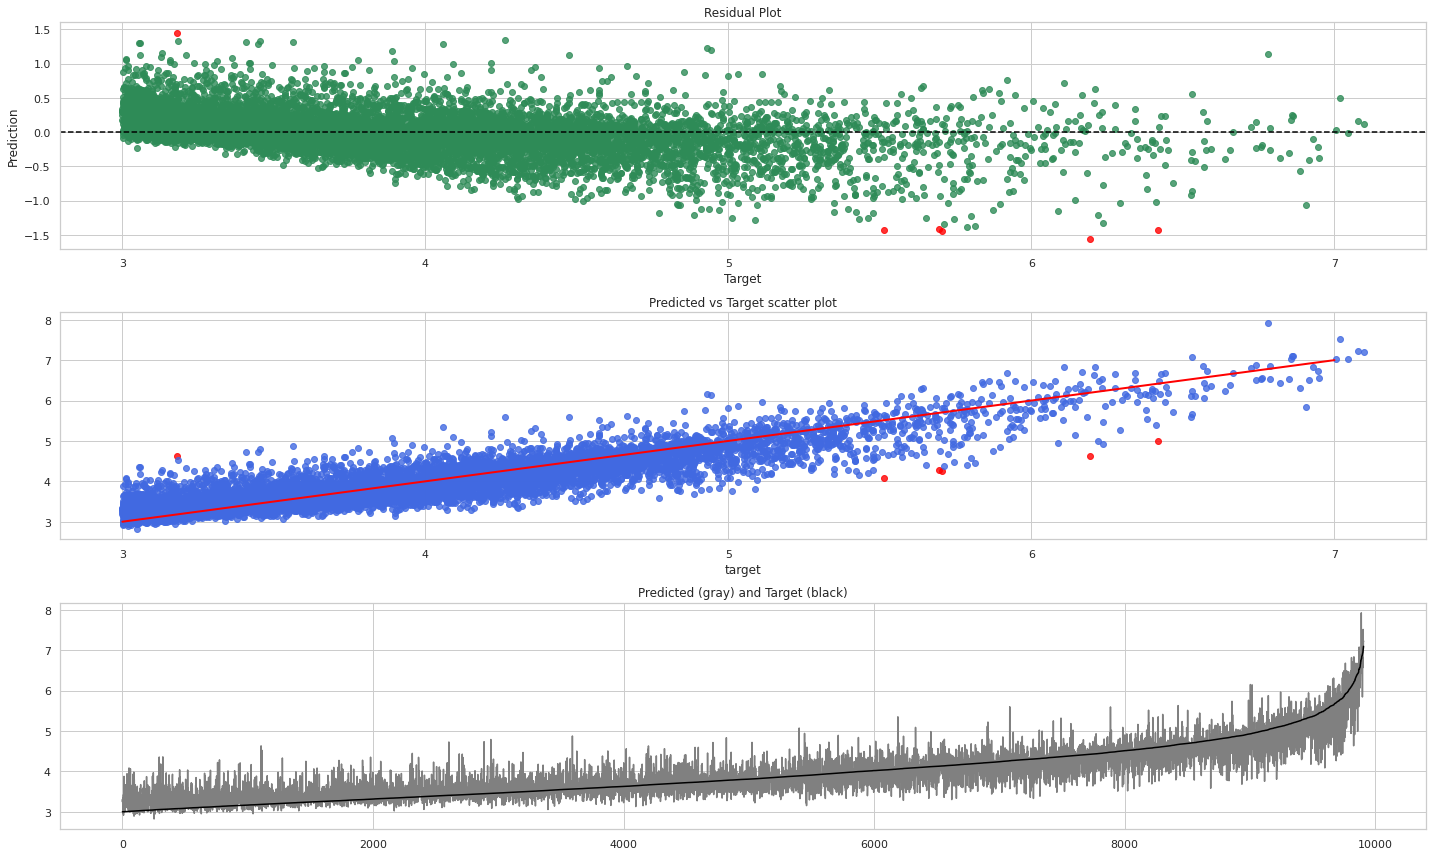

In [5]:
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)

y_test = np.log10(fixed_dbpedia_df.target).sort_values()
X_test = fixed_dbpedia_df.drop(columns=['subject', 'target']).reindex(y_test.index)


model = TransformedTargetRegressor(regressor=get_linear_pipeline(alpha=2, countries_threshold=0.97, utc_threshold=0.95),
                                   transformer=MinMaxScaler())
model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=True)
error_analysis_df = evaluator.get_error_analysis(fixed_dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)
error_analysis_df.head(10)

## Run SVR with fixed data
  * **RMSLE**: 0.27757

********************
Test RMSLE: 0.27757531360824356
Test RMSE: 240662.33139745996
********************
Train RMSLE: 0.2557634349053733
Train RMSE: 187774.04693419195
CPU times: user 8min 15s, sys: 611 ms, total: 8min 15s
Wall time: 8min 15s


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
4208,Karol_Bagh>,-1.763,5.703,3.941,505242.000,8728.949,-496513.051,<http://dbpedia.org/resource/Karol_Bagh>
6036,New_Athos>,1.696,3.181,4.877,1518.000,75297.069,73779.069,<http://dbpedia.org/resource/New_Athos>
4998,Logan_City>,-1.680,5.514,3.834,326615.000,6822.569,-319792.431,<http://dbpedia.org/resource/Logan_City>
3608,"Hidden_Hills,_California>",1.596,3.269,4.865,1856.000,73253.753,71397.753,"<http://dbpedia.org/resource/Hidden_Hills,_Cal..."
9381,"West_Hollywood_(Hollywood,_Florida)>",-1.537,4.784,3.247,60806.000,1767.511,-59038.489,<http://dbpedia.org/resource/West_Hollywood_(H...
5036,"Loni,_Ghaziabad>",-1.421,5.713,4.292,516082.000,19590.520,-496491.480,"<http://dbpedia.org/resource/Loni,_Ghaziabad>"
6524,Pago_Pago>,1.385,3.563,4.948,3656.000,88719.208,85063.208,<http://dbpedia.org/resource/Pago_Pago>
5013,Lomas_de_Zamora_Partido>,-1.378,5.788,4.409,613192.000,25667.213,-587524.787,<http://dbpedia.org/resource/Lomas_de_Zamora_P...
3654,Hobyo>,1.342,4.072,5.413,11800.000,259111.890,247311.890,<http://dbpedia.org/resource/Hobyo>
6761,Pimpri>,-1.323,6.238,4.914,1729320.000,82120.332,-1647199.668,<http://dbpedia.org/resource/Pimpri>


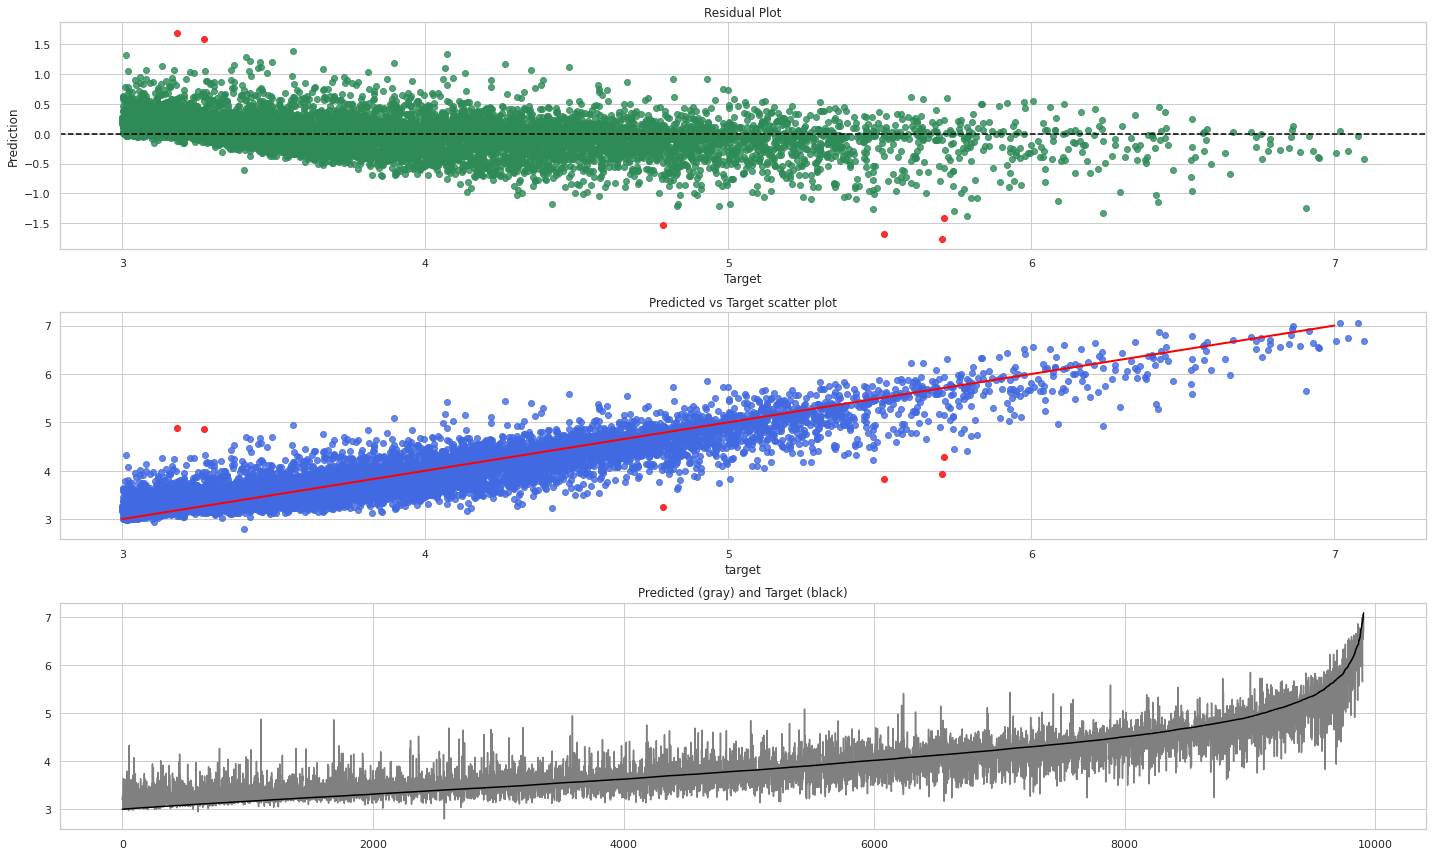

In [19]:
%%time
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)

y_test = np.log10(fixed_dbpedia_df.target).sort_values()
X_test = fixed_dbpedia_df.drop(columns=['subject', 'target']).reindex(y_test.index)

pipeline = get_svr_pipeline(countries_threshold=0.97, utc_threshold=0.95)
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
error_analysis_df = evaluator.get_error_analysis(fixed_dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)
error_analysis_df.head(10)

In [20]:
compare_population_with_web(error_analysis_df, limit=10).head(10)

1 Errors found while parsing wikipedia webpage. Make a manual check for: ['Logan_City']
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
2,Logan_City,True,326615.000,nan,0.000,Not found population table for <http://dbpedia...,https://en.wikipedia.org/wiki/Logan_City,<http://dbpedia.org/resource/Logan_City>
0,Karol_Bagh,False,505242.000,505242.000,0.000,,https://en.wikipedia.org/wiki/Karol_Bagh,<http://dbpedia.org/resource/Karol_Bagh>
1,New_Athos,False,1518.000,1518.000,0.000,,https://en.wikipedia.org/wiki/New_Athos,<http://dbpedia.org/resource/New_Athos>
3,"Hidden_Hills,_California",False,1856.000,1856.000,0.000,,https://en.wikipedia.org/wiki/Hidden_Hills%2C_...,"<http://dbpedia.org/resource/Hidden_Hills,_Cal..."
4,"West_Hollywood_(Hollywood,_Florida)",False,60806.000,60806.000,0.000,,https://en.wikipedia.org/wiki/West_Hollywood_%...,<http://dbpedia.org/resource/West_Hollywood_(H...
5,"Loni,_Ghaziabad",False,516082.000,516082.000,0.000,,https://en.wikipedia.org/wiki/Loni%2C_Ghaziabad,"<http://dbpedia.org/resource/Loni,_Ghaziabad>"
6,Pago_Pago,False,3656.000,3656.000,0.000,,https://en.wikipedia.org/wiki/Pago_Pago,<http://dbpedia.org/resource/Pago_Pago>
7,Lomas_de_Zamora_Partido,False,613192.000,613192.000,0.000,,https://en.wikipedia.org/wiki/Lomas_de_Zamora_...,<http://dbpedia.org/resource/Lomas_de_Zamora_P...
8,Hobyo,False,11800.000,11800.000,0.000,,https://en.wikipedia.org/wiki/Hobyo,<http://dbpedia.org/resource/Hobyo>
9,Pimpri,False,1729320.000,1729320.000,0.000,,https://en.wikipedia.org/wiki/Pimpri,<http://dbpedia.org/resource/Pimpri>


## Run Light XGBM with fixed data
  * **RMSLE**: 0.2659

********************
Test RMSLE: 0.26619267700593824
Test RMSE: 230741.23776136187
********************
Train RMSLE: 0.243113344122908
Train RMSE: 202960.96038605532
CPU times: user 32.8 s, sys: 86.8 ms, total: 32.9 s
Wall time: 2.97 s


,pretty_subject,log_diff,log_target,log_predicted,target,predicted,diff,subject
4208,Karol_Bagh>,-1.655,5.703,4.049,505242.000,11188.782,-494053.218,<http://dbpedia.org/resource/Karol_Bagh>
5013,Lomas_de_Zamora_Partido>,-1.649,5.788,4.138,613192.000,13745.195,-599446.805,<http://dbpedia.org/resource/Lomas_de_Zamora_P...
545,Bandundu_Province>,-1.617,6.906,5.290,8062463.000,194908.562,-7867554.438,<http://dbpedia.org/resource/Bandundu_Province>
4998,Logan_City>,-1.569,5.514,3.945,326615.000,8811.164,-317803.836,<http://dbpedia.org/resource/Logan_City>
5036,"Loni,_Ghaziabad>",-1.391,5.713,4.322,516082.000,20974.992,-495107.008,"<http://dbpedia.org/resource/Loni,_Ghaziabad>"
6377,Old_Goa>,1.252,3.407,4.659,2550.000,45598.436,43048.436,<http://dbpedia.org/resource/Old_Goa>
6761,Pimpri>,-1.240,6.238,4.998,1729320.000,99482.998,-1629837.002,<http://dbpedia.org/resource/Pimpri>
3490,Hatsingimari>,-1.229,5.744,4.515,555114.000,32732.736,-522381.264,<http://dbpedia.org/resource/Hatsingimari>
7760,Sausapor>,1.211,3.456,4.667,2856.000,46453.634,43597.634,<http://dbpedia.org/resource/Sausapor>
3608,"Hidden_Hills,_California>",1.201,3.269,4.470,1856.000,29497.407,27641.407,"<http://dbpedia.org/resource/Hidden_Hills,_Cal..."


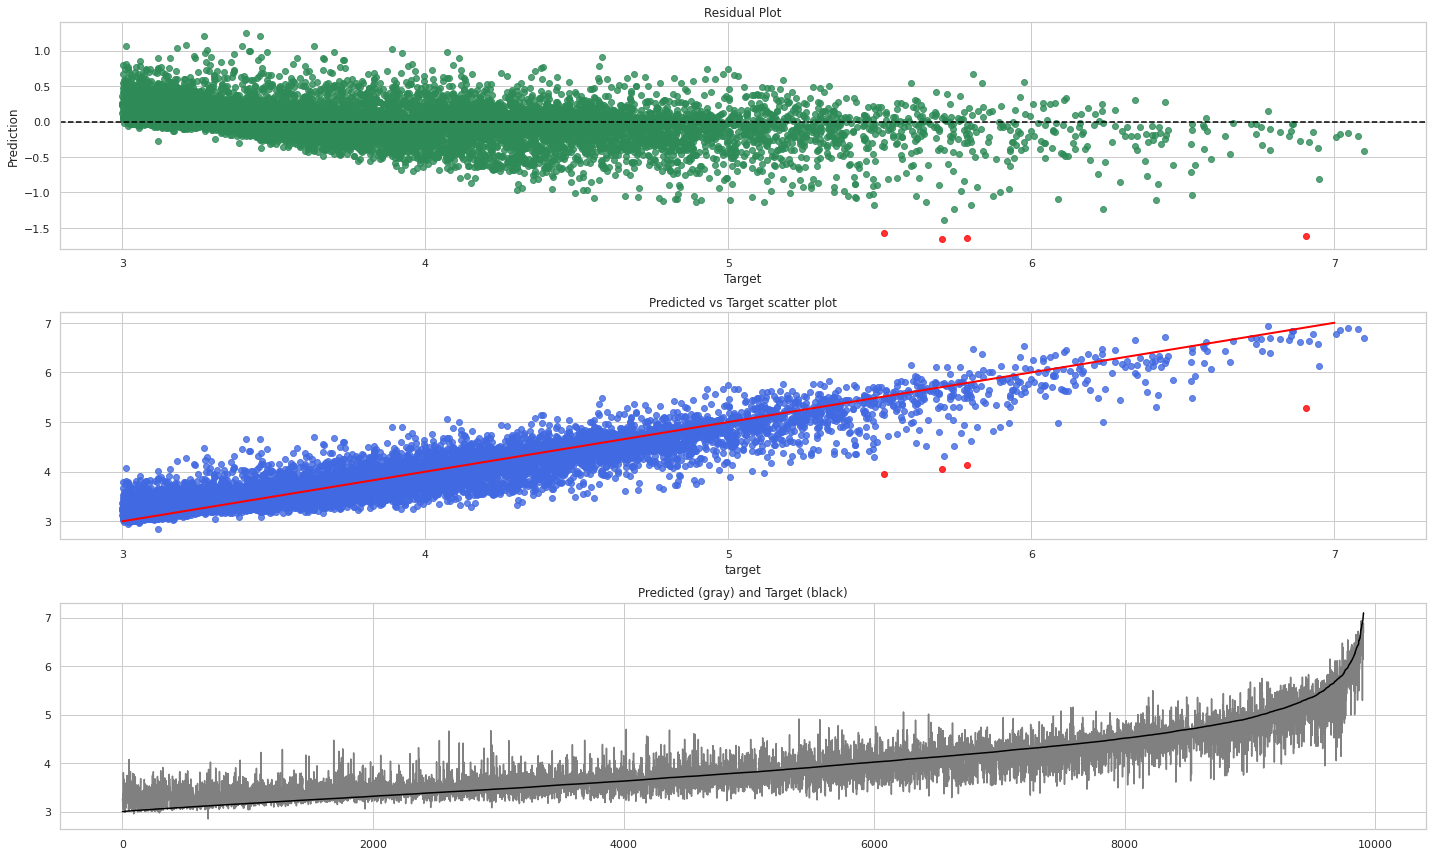

In [23]:
%%time
train_df = DataFrameRepository(version='last').get()
X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)

y_test = np.log10(fixed_dbpedia_df.target).sort_values()
X_test = fixed_dbpedia_df.drop(columns=['subject', 'target']).reindex(y_test.index)

pipeline = get_lxgb_pipeline()
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(eval_r2_score=False)
error_analysis_df = evaluator.get_error_analysis(fixed_dbpedia_df)
evaluator.plot_results(outlier_limit=1.4)
error_analysis_df.head(10)

### We now check in wikipedia.com (with our script) if the subjects with the most differences have the same population than dbpedia. It seems they do

In [9]:
compare_population_with_web(error_analysis_df, limit=10).head(10)

1 Errors found while parsing wikipedia webpage. Make a manual check for: ['Logan_City']
There are 0 suspicious subjects! Check if found values are real and fix the records


,pretty_subject,error,expected_value,found_value,relative_log_diff,message,wiki_link,subject
3,Logan_City,True,326615.000,nan,0.000,Not found population table for <http://dbpedia...,https://en.wikipedia.org/wiki/Logan_City,<http://dbpedia.org/resource/Logan_City>
0,Karol_Bagh,False,505242.000,505242.000,0.000,,https://en.wikipedia.org/wiki/Karol_Bagh,<http://dbpedia.org/resource/Karol_Bagh>
1,Lomas_de_Zamora_Partido,False,613192.000,613192.000,0.000,,https://en.wikipedia.org/wiki/Lomas_de_Zamora_...,<http://dbpedia.org/resource/Lomas_de_Zamora_P...
2,Bandundu_Province,False,8062463.000,8062463.000,0.000,,https://en.wikipedia.org/wiki/Bandundu_Province,<http://dbpedia.org/resource/Bandundu_Province>
4,"Loni,_Ghaziabad",False,516082.000,516082.000,0.000,,https://en.wikipedia.org/wiki/Loni%2C_Ghaziabad,"<http://dbpedia.org/resource/Loni,_Ghaziabad>"
5,Pimpri,False,1729320.000,1729320.000,0.000,,https://en.wikipedia.org/wiki/Pimpri,<http://dbpedia.org/resource/Pimpri>
6,Sausapor,False,2856.000,2856.000,0.000,,https://en.wikipedia.org/wiki/Sausapor,<http://dbpedia.org/resource/Sausapor>
7,Roussillon,False,450000.000,450000.000,0.000,,https://en.wikipedia.org/wiki/Roussillon,<http://dbpedia.org/resource/Roussillon>
8,Old_Goa,False,2550.000,2550.000,0.000,,https://en.wikipedia.org/wiki/Old_Goa,<http://dbpedia.org/resource/Old_Goa>
9,Hatsingimari,False,555114.000,555114.000,0.000,,https://en.wikipedia.org/wiki/Hatsingimari,<http://dbpedia.org/resource/Hatsingimari>


## We can also split the cities in 8 in a sensible way (small bins for small cities)
* [1,000;2,500)
* [2,500;5,000)
* [5,000;10,000)
* [10,000;50,000)
* [50,000;100,000)
* [100,000;500,000]
* [500,000;1,000,000)
* [1,000,000; +inf)
### We use Quadratic Kappa to measure the performance: https://www.kaggle.com/aroraaman/quadratic-kappa-metric-explained-in-5-simple-steps

Quadratic Kappa Score: 0.89
f1 score overall: 0.61


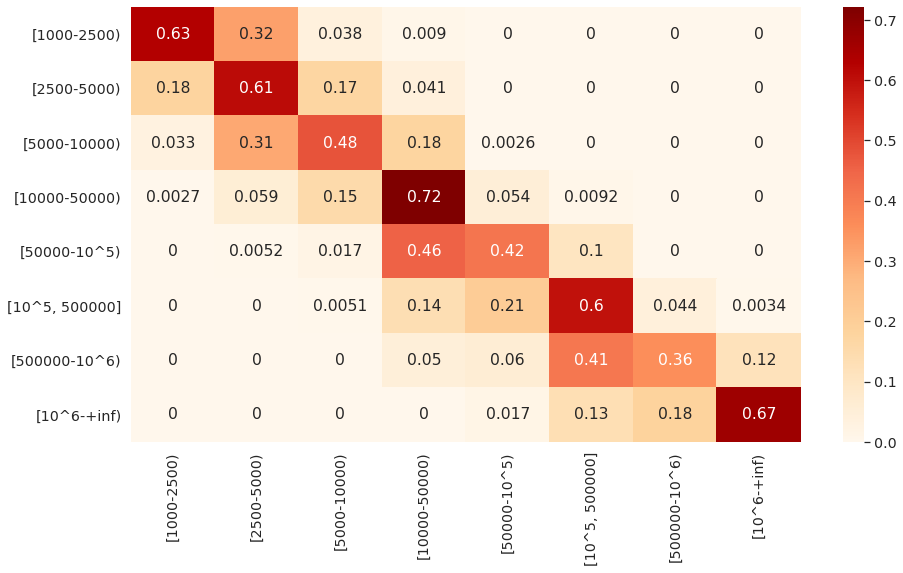

In [80]:
train_df = DataFrameRepository(version='last').get()
test_df = fixed_dbpedia_df.copy()

X_train = train_df.drop(columns=['subject', 'target'])
y_train = np.log10(train_df.target)
y_test = np.log10(test_df.target)
X_test = test_df.drop(columns=['subject', 'target'])

pipeline = get_lxgb_pipeline()
model = TransformedTargetRegressor(regressor=pipeline, transformer=MinMaxScaler())

model.fit(X_train, y_train)
evaluator = ModelEvaluator(model, X_test, y_test, X_train, y_train)

test_pred, train_pred = evaluator.evaluate_model(log=False)

bin_labels = [0, 1, 2 ,3, 4, 5, 6, 7]
bins = [0, 2499, 4999, 9999, 49999, 99999, 499_999, 999_999, np.inf]
pred_bin = pd.cut(10**test_pred, bins=bins, labels=bin_labels).astype(int)
y_test_bin = pd.cut(10**y_test, bins=bins, labels=bin_labels).astype(int)

print(f'Quadratic Kappa Score: {round(cohen_kappa_score(y_test_bin, pred_bin, weights="quadratic"), 2)}')
print(f'f1 score overall: {round(f1_score(y_test_bin, pred_bin, average="micro"), 2)}')

cm = confusion_matrix(y_test_bin, pred_bin, labels=bin_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels_cm = ['[1000-2500)', '[2500-5000)', '[5000-10000)','[10000-50000)','[50000-10^5)', '[10^5, 500000]', '[500000-10^6)','[10^6-+inf)']
df_cm = pd.DataFrame(cm, index = [i for i in labels], columns = [i for i in labels])
plt.figure(figsize = (15,8))
sns.set(font_scale=1.3)
sns.heatmap(df_cm, annot=True, cmap='OrRd')

## Even though the overall F1 score is not great (0.61), we can see the quadratic kappa score is pretty close to the maximum value of 1 (0.89), meaning that when we don't get the bin right, we are very close.